## Hands-on Exercise 1: Setup & Playground

We have defined a set of curated tools, and designed an agent to interpret natural language while using these tools.
Let's start with a few examples of what can be achieved with LLM Agents. It is particularly powerful when it comes to tasks like doing math or even querying your Pandas dataframe!

**Notes:**

LLM's don't always produce the same results.

In [ ]:
import warnings
with warnings.catch_warnings():
    warnings.filterwarnings("ignore",category=DeprecationWarning)
    import langchain

In [ ]:
# Read in the API keys
import os
root_folder = "./data/"
write_folder = "./"

deployment_name = os.getenv("OPENAI_API_DEPLOYMENT", "gpt-4")
model_name = os.getenv("OPENAI_API_MODEL", "gpt-4")

# Import libraries and pre-defined tools

import openai
import pandas as pd
from langchain.agents import initialize_agent, Tool, load_tools
from langchain.agents import AgentType
from langchain.chat_models import AzureChatOpenAI
from langchain_experimental.agents.agent_toolkits.pandas.base import create_pandas_dataframe_agent
from langchain.utilities import SerpAPIWrapper, GoogleSearchAPIWrapper
from langchain.prompts import MessagesPlaceholder, ChatPromptTemplate
from langchain.tools.azure_cognitive_services import (
    AzureCogsFormRecognizerTool,
    AzureCogsSpeech2TextTool,
    AzureCogsText2SpeechTool,
)
from langchain.chat_models import AzureChatOpenAI
from langchain.memory import ConversationBufferMemory
from langchain.agents import initialize_agent, AgentType, AgentExecutor, Tool

from langchain_experimental.agents.agent_toolkits.python.base import create_python_agent
from langchain_experimental.agents.agent_toolkits.pandas.base import create_pandas_dataframe_agent
from langchain_experimental.tools.python.tool import PythonREPLTool

# Define your LLM
llm = AzureChatOpenAI(temperature=0.0, deployment_name=deployment_name, model_name=model_name)

**Exploring Built-In Tools**

1.   Limitations of Vanilla LLMs
2.   Using the Math Tool
3.   Talking to your CSV data


------------------------------
1. Limitations of Vanilla LLMs

In [ ]:
# Out-of-the-box LLM prediction
math_query = "What is 278 * 903?"
answer = llm.invoke(math_query)
print(answer.content)

2. Let's now try using a Agent equipped with a Math tool

In [ ]:
math_agent= initialize_agent(
    tools=load_tools(["llm-math"], llm=llm),
    llm=llm,
    agent=AgentType.OPENAI_FUNCTIONS,
    return_direct=True)

In [ ]:
# Calculate using Math Agent
math_agent.run(math_query)

You can notice the difference between the two. The LLM by itself can't always do math but this problem can be circumvented by connecting an LLM with a calculator!

Try finding other such cases

In [ ]:
math_query = "" # TODO
answer = llm.invoke(math_query)
print(answer.content)

In [ ]:
math_agent.run(math_query)

3. Talking to your CSV data

---



Here we will use a pandas agent that allows users to query datasets directly through text prompts

In [ ]:
#Read in csv file, create a pandas dataframe agent, and query it
data_df = pd.read_csv(f"{root_folder}/california_housing_test.csv")
csv_agent = create_pandas_dataframe_agent(llm, data_df, verbose=True)
csv_agent.run("Show me the first few entries of the DataFrame")

In [ ]:
csv_agent.run("Are there are any duplicate entries in the dataframe?")

In [ ]:
csv_agent.run("Show me interesting trends in the data and make some nice plots")

In [ ]:
csv_agent.run("Fit a linear regression model with median house value as the dependent variable and the and the median income as the independent. Print the MSE.")

In [ ]:
csv_agent.run("Now fit a ridge regression model, with median house value as the dependent variable and the and the median income as the independent. Tune the hyperparameter for the ridge regression. Print the resulting MSE.")

In [ ]:
# Try your own query
csv_query = "" # TODO
csv_agent.run(csv_query)

# **Hands-on Exercise 2: Design your own Agent**


---


As the owner of Beverage Inc., a reputed brand selling beverages, you need to keep an eye out for market trends and potential disruptions caused by industry-relevant news.


In one of the recent data mining activities, you came across some potentially disrupting news.


Recently, the Chief Medical Officer of a major consumer country highlighted the problem the general population is facing due to their diet in an interview.


Fearing legislation might get passed to mitigate these health effects in the society, you would like to take proactive measures and identify products from your inventory that can be affected.


You are tasked with helping the company by designing a General agent to perform ad-hoc analysis including an Extraction-Transformation-Load operation.


---


You can enlist the services of the following tools:

*Search*

*AzureCogsFormRecognizerTool() - OCR from images*

*AzureCogsSpeech2TextTool() - Convert speech to text*

*AzureCogsText2SpeechTool() - Convert text to speech*


All the helper files are located in the folder. You need to provide the correct files with the appropriate prompt to the agent to help solve this case.

In [ ]:
# Prepare Short-Term Memory for Agent. This will help the Agent remember your conversation.
agent_kwargs = {"extra_prompt_messages": [MessagesPlaceholder(variable_name="memory")],}
conversational_memory = ConversationBufferMemory(memory_key="memory", return_messages=True)

In [ ]:
# Load the relevant tools to be used by the Agent
search = SerpAPIWrapper()
tools = [
    # List your tools here
    # an example here is the search tool
    Tool(
        name="Search",
        func=search.run,
        description="useful for when you need to answer questions about current events",
    ),
    # Uncomment the tools you'd like the Agent to use. Remember, we'll be working with images and audio files.
    #AzureCogsFormRecognizerTool(), #TODO
    #AzureCogsSpeech2TextTool(), #TODO
    #AzureCogsText2SpeechTool(), #TODO
]

In [ ]:
#Initialize the Agent. Here we can set some parameters including the tools and memory options
main_agent = initialize_agent(
    tools,
    llm=llm,
    agent=AgentType.OPENAI_FUNCTIONS,
    verbose=True,
    handle_parsing_errors=True,
    memory=conversational_memory,
    agent_kwargs=agent_kwargs,
    return_only_outputs=True,
)

**Query the audio recording**

Let's load the audio recording.

In [ ]:
from IPython.display import Audio, display

sound_file = root_folder + "audio_1.wav"

# Play the audio recording
display(Audio(sound_file, autoplay=False))

In [ ]:
# Explore the audio file. The first query is shown here as an example.
# Make sure you have included the right tools for this!

query = f"Convert {sound_file} to text"
main_agent.run(query)

From the transcribed audio, extract the unhealthy nutrient.

In [ ]:
query = "" #TODO
unhealthy_nutrient = main_agent.run(query)

**Analyze your inventory - Direct the Agent to read-in the Nutrition labels of your products**

We will utilize some examples of nutrition label images like the following:

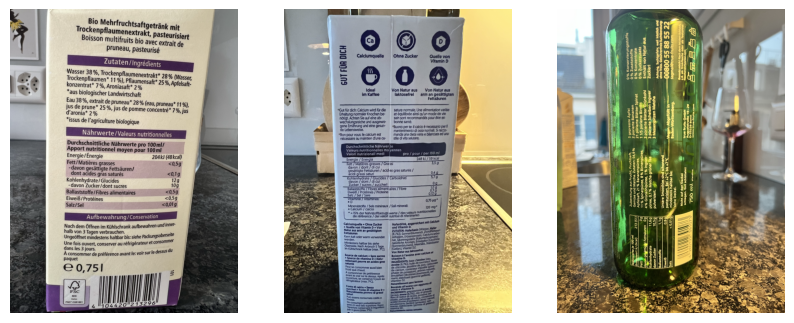

Extract the Nutrition labels from the images stored as image_1.png, image_2.png and image_3.png along with the product labels

In [ ]:
# The for-loop will run over the 3 images provided. You can use f-strings to include variables in your text prompt.
# You may refer to the previous query for an example on how to use f-strings.
for i in range(1,4):
    image_query = f"{root_folder} + image_{i}.png" #TODO - only the path has been already provided in the query, you need to fill in the rest.
    main_agent.run(image_query)

Extract the info for the unhealthy nutrient.
The previous conversation and details are stored in the Agent's short-term memory!

In [ ]:
query = "" #TODO
main_agent.run(query)

Identify the product(s) in your inventory that can be affected due to high levels of the unhealthy item

In [ ]:
query = "" #TODO
main_agent.run(query)

**Perform Competition Analysis Online**

Search for products that are similar to the 2nd product in the inventory

In [ ]:
query = "" #TODO
main_agent.run(query)

**Bonus part: Try quering another audio file where a user's preference for an item is stored. Find out that item.**

You may need to clear the buffer memory and rescan the images.

In [ ]:
#Run this cell to clear the memory buffer
#conversational_memory.clear()

Rescan the labels from the images. You can use the previously defined image query.

In [ ]:
for i in range(1,4):
    main_agent.run() # TODO

The audio file is stored as audio_2.wav

In [ ]:
sound_file_2 = root_folder + "audio_2.wav"

# Play the audio recording
display(Audio(sound_file_2, autoplay=False))

In [ ]:
query = "" #TODO
main_agent.run(query)

# **Enhance your Agent** - Build your own Tool(s)

It is also possible to define your own functions to transform data and mark it as a tool that can be used by an agent.
We will define such tools to calculate the Nutriscore based on the nutrition labels, and to write data in a csv and json file.

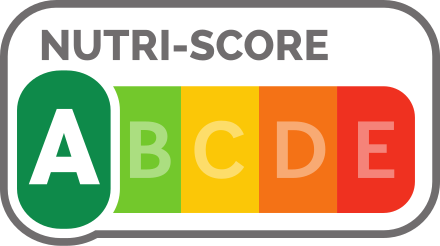

In [ ]:
from langchain.tools import tool

# The docstring helps the Agent find the correct tool for a given user query

@tool
def calculate_nutriscore(energy_kcal, sugars, saturated_fats, fibers, proteins):
    """
    Calculate the Nutri-Score for beverages based on their nutritional content

    Args:
    - energy_kj (kJ/100ml)
    - sugars (g/100ml)
    - saturated_fats (g/100ml)
    - fibers (g/100ml)
    - proteins (g/100ml)

    Returns:
    - Nutri-Score (A, B, C, D, E)
    """

    # Negative points
    if energy_kcal<= 7.2:
        energy_points = 1
    elif energy_kcal<= 14.3:
        energy_points = 2
    elif energy_kcal<= 21.5:
        energy_points = 3
    elif energy_kcal<= 28.5:
        energy_points = 4
    elif energy_kcal<= 35.9:
        energy_points = 5
    elif energy_kcal<= 43.0:
        energy_points = 6
    elif energy_kcal<= 50.2:
        energy_points = 7
    elif energy_kcal<= 57.4:
        energy_points = 8
    elif energy_kcal<= 64.5:
        energy_points = 9
    else:
        energy_points = 10

    sugar_points = 0
    if sugars <= 4.5:
        sugar_points = 2
    elif sugars <= 9:
        sugar_points = 5
    elif sugars <= 13.5:
        sugar_points = 8
    else:
        sugar_points = 10

    negative_points = energy_points + sugar_points

    # Positive points
    fiber_points = 0
    if fibers < 0.7:
        fiber_points = 0
    elif fibers <= 1.4:
        fiber_points = 1
    elif fibers <= 2.1:
        fiber_points = 2
    elif fibers <= 2.8:
        fiber_points = 3
    elif fibers <= 3.5:
        fiber_points = 4
    else:
        fiber_points = 5

    protein_points = 0
    if proteins < 1.6:
        protein_points = 0
    elif proteins <= 3.2:
        protein_points = 1
    elif proteins <= 4.8:
        protein_points = 2
    elif proteins <= 6.4:
        protein_points = 3
    elif proteins <= 8:
        protein_points = 4
    else:
        protein_points = 5

    positive_points = fiber_points + protein_points

    # Final score
    score = negative_points - positive_points

    # Determine Nutri-Score
    # Determine the Nutri-Score category
    if -15 <= score < -1:
        category = 'A (Green)'
    elif -1 <= score <= 2:
        category = 'B (Light Green)'
    elif 3 <= score <= 10:
        category = 'C (Yellow)'
    elif 11 <= score <= 18:
        category = 'D (Orange)'
    else:
        category = 'E (Red)'
    return category

In [ ]:
import csv
import json

@tool
def write_to_csv(filename, data): # TODO
    """
    TODO: Write a meaningful docstring to help your Agent find the tool.
    You might need to include specific-words to give it priority for certain tasks
    so that the agent knows which tool to pick.
    """
    file_path = os.path.join(write_folder, filename)
    with open(file_path, 'w', newline='') as csvfile:
        csv_writer = csv.writer(csvfile)

        # Write the data rows
        for row in data:
            csv_writer.writerow([value for value in row])


@tool
def write_to_json(filename, data): # TODO
    """
    TODO: Write a meaningful docstring to help your Agent find the tool.
    You might need to include specific-words to give it priority for certain tasks
    so that the agent knows which tool to pick.
    """
    file_path = os.path.join(write_folder, filename)
    with open(file_path, 'w') as json_file:
        json.dump(data, json_file)

In [ ]:
# Enhance your Agent with the newly defined tools
# In order to include new tools for the agent, simply insert the names of the
# functions marked with @tool decorator.

new_agent = initialize_agent(
    tools=tools + [new_tool_1] + [new_tool_2] + [new_tool_3], # TODO
    llm=llm,
    agent=AgentType.OPENAI_FUNCTIONS,
    verbose=True,
    handle_parsing_errors=True,
    memory=conversational_memory,
    agent_kwargs=agent_kwargs,
    return_direct=True
)

In [ ]:
# Run this cell to clear the memory buffer
#conversational_memory.clear()

Rescan the labels from the images

In [ ]:
# You may use the image query from before
for i in range(1,4):
    new_agent.run() # TODO

You need to save the nutritional data as a json file. Invoke the write_to_json tool after formatting the nutrition data

In [ ]:
query = "" # TODO
new_agent.run(query)

**Calculate the Nutriscore of the products by invoking the nutriscore tool**

Make sure you're passing the arguments in the correct unit, for example energy should be in kcal.

In [ ]:
query = "" # TODO
new_agent.run(query)

**Write the nutriscore of the most unhealthy product(s) in a file called nutriscore.csv**

You might need to format the data as rows before saving it. Simply include this request in the prompt.

In [ ]:
query = "" # TODO
new_agent.run(query)

# Mission Accomplished!
Congrats, you've successfully directed the LLM agent to help prepare Beverage Inc. for the rocky times ahead.

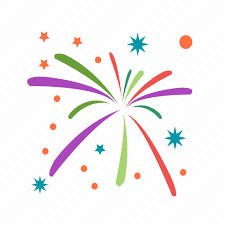